Мы решили открыть небольшое кафе в Москве. Оно оригинальное — гостей должны обслуживать роботы. Проект многообещающий, но дорогой. Вместе с партнёрами мы решились обратиться к инвесторам. Их интересует текущее положение дел на рынке — сможем ли мы снискать популярность на долгое время, когда все зеваки насмотрятся на роботов-официантов?

У нас есть открытые данные о заведениях общественного питания в Москве. 
Будем следовать следующему плану:
- [загрузим данные и подготовим их для анализа](#load)
- [проведем непосредственно сам анализ](#analysis)
- [сделаем вывод о перспективности открытия заведения с роботами](#output)

## Загрузка и предобработка данных
<a id='load'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express  as  px 
from plotly import graph_objects as go
import warnings
warnings.filterwarnings('ignore')

Библеотеки загружены. Теперь изучим сами данные и займемся их предобработкой: проверим типы, наличие пропусков и дубликатов

In [2]:
df = pd.read_csv('C:\\Users\\Александр\Datasets/rest_data.csv')

In [3]:
df.head(10)

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50
5,27429,СТОЛ. ПРИ ГОУ СОШ № 1051,нет,столовая,"город Москва, Абрамцевская улица, дом 15, корп...",240
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
7,20957,Буфет МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",90
8,20958,КПФ СЕМЬЯ-1,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",150
9,28858,Столовая МТУСИ,нет,столовая,"город Москва, Авиамоторная улица, дом 8, строе...",120


Проверим, есть ли какие-лио заведомо некорректные значения (или не понятные нам) в столбцах

In [4]:
display(df['chain'].unique())

array(['нет', 'да'], dtype=object)

In [5]:
display(df['object_type'].unique())

array(['кафе', 'столовая', 'закусочная',
       'предприятие быстрого обслуживания', 'ресторан', 'кафетерий',
       'буфет', 'бар', 'магазин (отдел кулинарии)'], dtype=object)

Возможно, для удобства будет нелишним сократить некоторые категориальные значения в столбце - сделаем это

In [6]:
df['object_type'] = df['object_type'].replace(['магазин (отдел кулинарии)'], 'кулинария')
df['object_type'] = df['object_type'].replace(['предприятие быстрого обслуживания'], 'ПБО')

С корректностью данных все нормально. Проверим корректность типов.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           15366 non-null  int64 
 1   object_name  15366 non-null  object
 2   chain        15366 non-null  object
 3   object_type  15366 non-null  object
 4   address      15366 non-null  object
 5   number       15366 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


С типами тоже все ок. Проверим наличие дубликатов. По здравом размышлении нам стоит удалить либо полные дубликаты строк, либо повторяющиеся значения в столбце id (их быть не должно).

In [8]:
df.duplicated().sum()

0

In [9]:
df['id'].duplicated().sum()

0

Пропусков мы тоже не наблюдаем. Данные готовы к анализу

## Анализ данных
<a id='analysis'></a>

### Соотношение видов объектов общественного питания по количеству


Для начала посмотрим, какой из видов объектов самый популярный

In [10]:
df_types = (
    df.groupby('object_type')['object_name']
    .count().reset_index().sort_values(by='object_name', ascending=False)
)

In [11]:
df_types

,object_type,object_name
4,кафе,6099
8,столовая,2587
7,ресторан,2285
0,ПБО,1923
1,бар,856
2,буфет,585
5,кафетерий,398
3,закусочная,360
6,кулинария,273


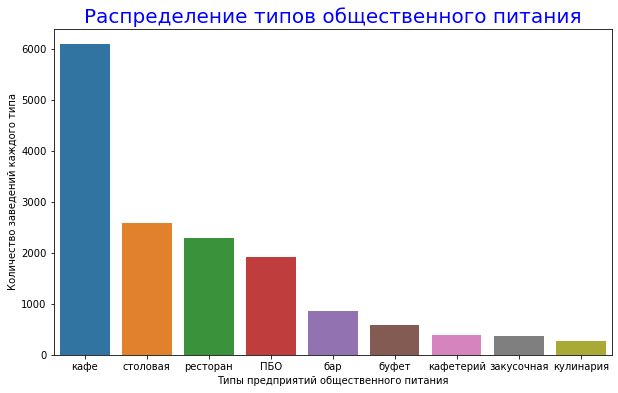

In [12]:
plt.figure(figsize=(10,6))
sns.barplot(x='object_type', y='object_name', data=df_types)
plt.xticks(rotation=0)
plt.title('Распределение типов общественного питания', color = 'blue', fontsize=20)
plt.xlabel('Типы предприятий общественного питания')
plt.ylabel('Количество заведений каждого типа')
#plt.grid(linewidth=0.3)
plt.show()

Возможно, нам стоит присмотреться к 4 самым популярным видам объектов - по крайней мере, они самые популярные

### Соотношение сетевых и несетевых заведений по количеству

In [13]:
df_chain = df.groupby('chain')['id'].count().reset_index()
chain_bool = df['chain'].unique().tolist()
id_chain_count = df_chain['id'].tolist()
df_chain

,chain,id
0,да,2968
1,нет,12398


In [14]:
df_chain['total'] = df_chain['id'].sum()
df_chain['%'] = df_chain['id'] / df_chain['total'] * 100
df_chain['%'] = df_chain['%'].round(2)
df_chain

,chain,id,total,%
0,да,2968,15366,19.32
1,нет,12398,15366,80.68


Если 80% точек не относится к сетям - значит ли это, что сетевые менее выгодные? Не факт, надо смотреть на другие параметры

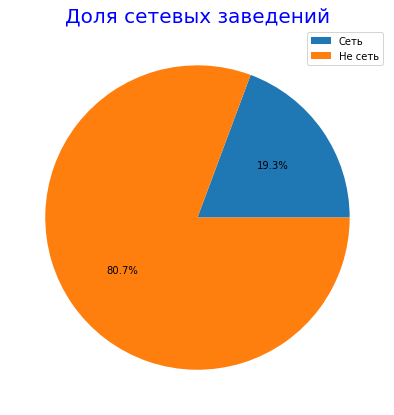

In [15]:
plt.figure(figsize=(12,7))
labels = ['Сеть', 'Не сеть']
plt.title('Доля сетевых заведений', color = 'blue', fontsize=20, )
plt.pie(df_chain['%'], autopct='%1.1f%%')
plt.legend(labels)
plt.show()

### Вид общественного питания и сетевое распространение

Теперь выясним, для какого вида общественного питания характерно сетевое распорстранение

In [16]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [17]:
df_type_chain_percent = df.groupby(['object_type', 'chain'])['id'].count().reset_index()
df_type_chain_percent.head()

,object_type,chain,id
0,ПБО,да,791
1,ПБО,нет,1132
2,бар,да,37
3,бар,нет,819
4,буфет,да,11


In [18]:
df_type_chain_percent = df_type_chain_percent.merge(df_types, on='object_type', how='left')
df_type_chain_percent.head()

,object_type,chain,id,object_name
0,ПБО,да,791,1923
1,ПБО,нет,1132,1923
2,бар,да,37,856
3,бар,нет,819,856
4,буфет,да,11,585


In [19]:
df_type_chain_percent['%'] = df_type_chain_percent['id'] / df_type_chain_percent['object_name'] * 100
df_type_chain_percent.head()

,object_type,chain,id,object_name,%
0,ПБО,да,791,1923,41.133645
1,ПБО,нет,1132,1923,58.866355
2,бар,да,37,856,4.322430
3,бар,нет,819,856,95.677570
4,буфет,да,11,585,1.880342


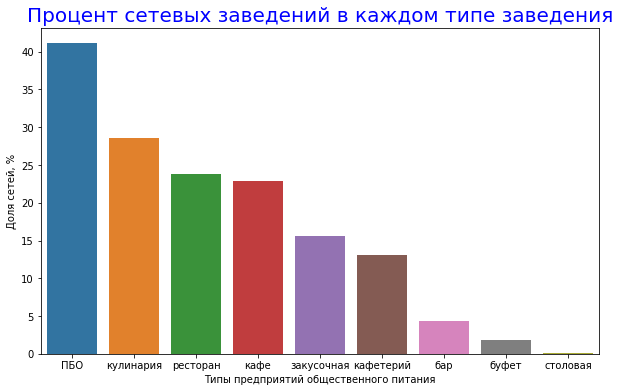

In [20]:
plt.figure(figsize=(10,6))
sns.barplot(x='object_type', y='%', data=df_type_chain_percent.query('chain == "да"').sort_values(by='%', ascending=False))
plt.xticks(rotation=0)
plt.title('Процент сетевых заведений в каждом типе заведения', color = 'blue', fontsize=20)
plt.xlabel('Типы предприятий общественного питания')
#plt.grid(linewidth=0.3)
plt.ylabel('Доля сетей, %')
plt.show()

Если по сетевой модели в большей степени  среди всех видов распространяются ПБО - значит ли это, что эта модель наиболее привлекательна с точки зрения получения прибыли? Однозначного ответа не можем дать

### Что характерно для сетевых заведений: много заведений с небольшим числом посадочных мест в каждом или мало заведений с большим количеством посадочных мест?

In [21]:
df.query('chain == "да"').head()

,id,object_name,chain,object_type,address,number
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
6,148815,Брусника,да,кафе,"город Москва, переулок Сивцев Вражек, дом 6/2",10
13,22579,Алло Пицца,да,кафе,"город Москва, улица Авиаторов, дом 14",32
16,144107,Суши Wok,да,ПБО,"город Москва, Азовская улица, дом 3",7
18,58565,Тануки,да,ресторан,"город Москва, Большая Академическая улица, дом 65",160


In [22]:
df_chain = df.query('chain == "да"').groupby('object_name').agg({'id': 'count', 'number': 'mean'})
df_chain.sort_values(by='id', ascending=False).head()

,id,number
object_name,,
KFC,155,55.341935
Шоколадница,141,56.170213
Макдоналдс,122,81.500000
Бургер Кинг,122,45.016393
Домино'с Пицца,86,18.209302


Посмотрим на указанное соотношение по сырым данным

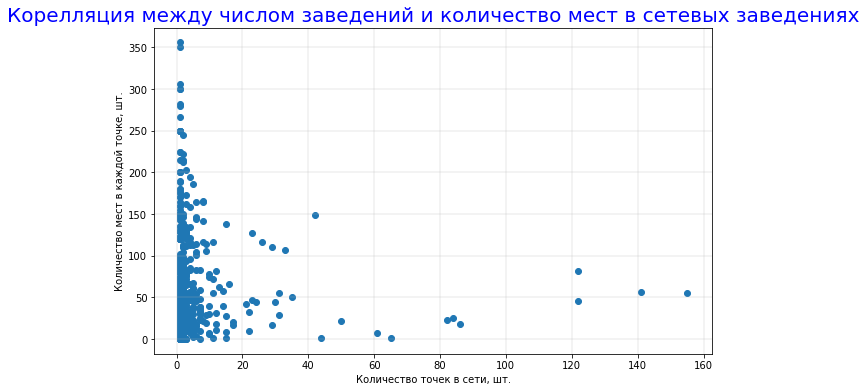

In [23]:
# скаттер по сырым данным
plt.figure(figsize=(10,6))
plt.scatter(x='id', y='number', data=df_chain) 
plt.title('Корелляция между числом заведений и количество мест в сетевых заведениях', color = 'blue', fontsize=20)
plt.xlabel('Количество точек в сети, шт.')
plt.ylabel('Количество мест в каждой точке, шт.')
plt.grid(linewidth=0.3)
plt.show()

По сырым данным видим, что есть слабая зависимость: для сетей чуть больше характерно наличие многих заведений с небольшим числом посадочных мест в каждом

In [24]:
df_chain.describe()

,id,number
count,724.000000,724.000000
mean,4.099448,60.320759
std,12.625954,56.132763
min,1.000000,0.000000
25%,1.000000,20.000000
50%,1.000000,45.000000
75%,2.000000,83.625000
max,155.000000,356.000000


А что, если посмотреть на очищенные от выбросов данные?

In [25]:
display(np.percentile(df_chain['id'], [90, 95, 99]))

array([ 6.  , 12.  , 64.08])

In [26]:
display(np.percentile(df_chain['number'], [90, 95, 99]))

array([134.4 , 164.9 , 262.32])

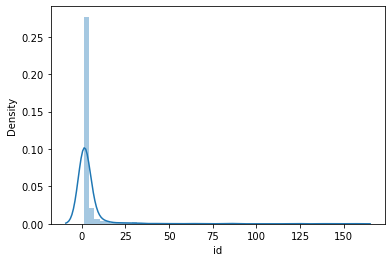

In [27]:
sns.distplot(df_chain['id']) 
plt.show()

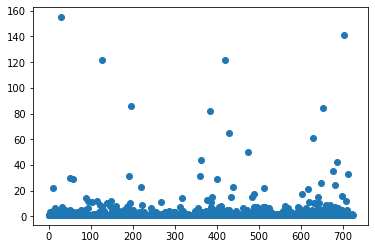

In [28]:
x_values = pd.Series(range(0,len(df_chain)))
plt.scatter(x_values, df_chain['id'])
plt.show()

Примем за границы аномальности значения в 16 по количеству объектов в сети и 160 по количеству мест в каждом

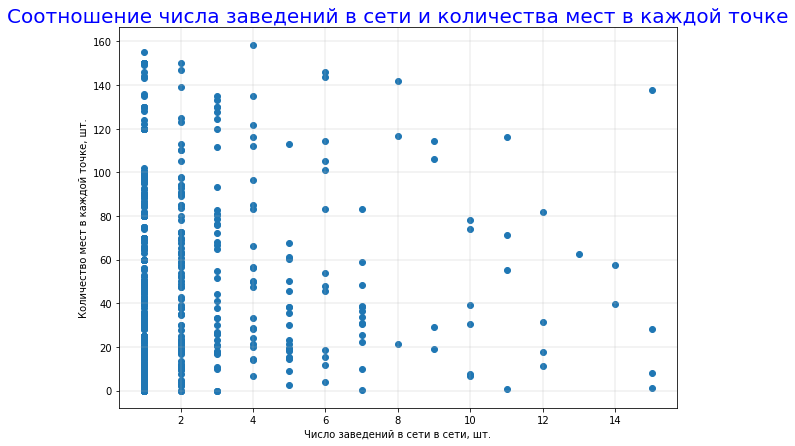

In [29]:
# тот же скаттер по очищенным данным без регресии для презентации
plt.figure(figsize=(10,7))
plt.scatter(x='id', y='number', data=df_chain.query('id < 16 and number < 160')) 
plt.title('Соотношение числа заведений в сети и количества мест в каждой точке', color = 'blue', fontsize='20')
plt.xlabel('Число заведений в сети в сети, шт.')
plt.ylabel('Количество мест в каждой точке, шт.')
plt.grid(linewidth=0.3)
plt.show()

По очищенным данным нельзя сделать вывод, что для сетевых заведений есть обратная зависимость между количеством заведений в сети и числом мест в каждрй точке

### Cреднее количество посадочных мест lля каждого вида объекта общественного питания . 

In [30]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


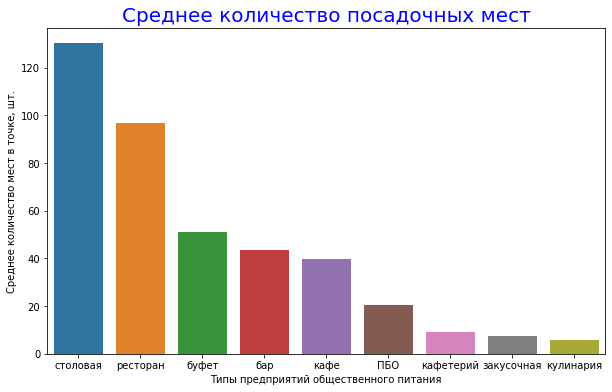

In [31]:
plt.figure(figsize=(10,6))
sns.barplot(x='object_type', y='number', data=df.groupby('object_type')['number'].mean().reset_index().sort_values(by='number', ascending=False))
plt.xticks(rotation=0)
plt.title('Среднее количество посадочных мест', color = 'blue', fontsize=20)
plt.xlabel('Типы предприятий общественного питания')
plt.ylabel('Среднее количество мест в точке, шт.')
#plt.grid(linewidth=0.3)
plt.show()

Как видим, больше всего мест из объектов питания представлют столовая и ресторан. Но чтобы сделать вывод о том, что эффективнее - необхожимы финансовые данные (средний чек, рентабельность и тд), которых у нас нет

### Выделение в отдельный столбец информации об улице из столбца address 

In [32]:
df.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


In [33]:
pattern = '\,(([а-яА-Я0-9\-ёй\s"]+)?(улица|переулок|шоссе|проспект|проезд)([а-яА-Яёй0-9\-\s"]+)?)\,'
df['street'] = df['address'].str.extract(pat=pattern)[0]
#df.head(50)
df.head()


,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


### Топ-10 улиц по количеству объектов общественного питания

In [34]:
from io import BytesIO
import requests
spreadsheet_id = '19uOzCC316RoPs52sceQeFP2j36M1yohdAZwCHMM0D5c'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
r = requests.get(file_name)
streets = pd.read_csv(BytesIO(r.content))


In [35]:
streets.head()

,streetname,areaid,okrug,area
0,Выставочный переулок,17,ЦАО,Пресненский район
1,улица Гашека,17,ЦАО,Пресненский район
2,Большая Никитская улица,17,ЦАО,Пресненский район
3,Глубокий переулок,17,ЦАО,Пресненский район
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район


In [36]:
pattern2 = '(([а-яА-Я0-9\-ёй\s"]+)?(улица|переулок|шоссе|проспект|проезд)([а-яА-Яёй0-9\-\s"]+)?)'
streets['street'] = streets['streetname'].str.extract(pat=pattern2)[0]
streets.head()

,streetname,areaid,okrug,area,street
0,Выставочный переулок,17,ЦАО,Пресненский район,Выставочный переулок
1,улица Гашека,17,ЦАО,Пресненский район,улица Гашека
2,Большая Никитская улица,17,ЦАО,Пресненский район,Большая Никитская улица
3,Глубокий переулок,17,ЦАО,Пресненский район,Глубокий переулок
4,Большой Гнездниковский переулок,17,ЦАО,Пресненский район,Большой Гнездниковский переулок


In [37]:
top10_streets = df.groupby('street')['id'].count().reset_index().sort_values(by='id', ascending=False).head(10)
top10_streets['street'] = top10_streets['street'].str.strip()
top10_streets

,street,id
1246,проспект Мира,204
926,Профсоюзная улица,182
632,Ленинградский проспект,171
379,Варшавское шоссе,164
635,Ленинский проспект,147
1242,проспект Вернадского,132
622,Кутузовский проспект,114
562,Каширское шоссе,112
568,Кировоградская улица,110
633,Ленинградское шоссе,100


In [38]:
top10_streets = top10_streets.merge(streets, on='street', how='left')
top10_streets.head()

,street,id,streetname,areaid,okrug,area
0,проспект Мира,204,проспект Мира,70,СВАО,Алексеевский район
1,проспект Мира,204,проспект Мира,86,СВАО,Ярославский Район
2,проспект Мира,204,проспект Мира,78,СВАО,Район Марьина роща
3,проспект Мира,204,проспект Мира,79,СВАО,Останкинский район
4,проспект Мира,204,проспект Мира,81,СВАО,Район Ростокино


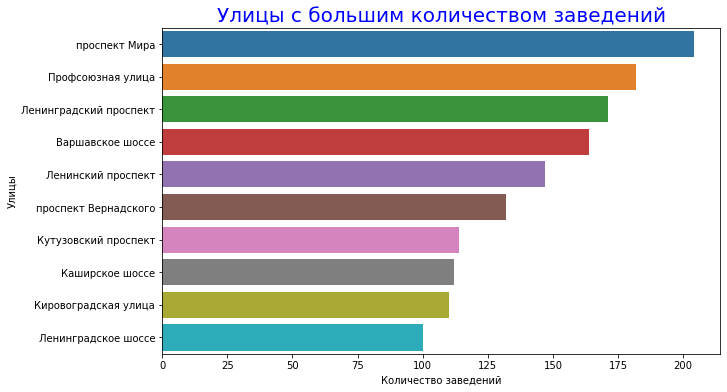

In [39]:
plt.figure(figsize=(10,6))
sns.barplot(x='id', y='street', data=top10_streets.sort_values(by='id', ascending=False))
plt.title('Улицы с большим количеством заведений', color = 'blue', fontsize=20)
plt.xlabel('Количество заведений')
plt.ylabel('Улицы')
plt.show()

Чтобы ответить на вопрос - на какой улице лучше открывать заведение - нужно учитывать население местное: сколько их проживает на конкретной площади и каков конкуренция между заведениями (сколько потенциальных клиентов приходится на каждое заведение)

### Улицы с одним объектом общественного питания

In [40]:
df.head()

,id,object_name,chain,object_type,address,number,street
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40,Абрамцевская улица
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50,Абрамцевская улица


In [41]:
df['street'] = df['street'].str.strip()

In [42]:
streets['street'] = streets['street'].str.strip()

In [43]:
df = df.merge(streets, on='street', how='left')
df.head()

,id,object_name,chain,object_type,address,number,street,streetname,areaid,okrug,area
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48,улица Егора Абакумова,улица Егора Абакумова,86.0,СВАО,Ярославский Район
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина,18.0,ЦАО,Таганский район
2,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина,117.0,ЮВАО,Нижегородский район
3,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35,улица Талалихина,улица Талалихина,133.0,ЮЗАО,Район Южное Бутово
4,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95,Абельмановская улица,Абельмановская улица,18.0,ЦАО,Таганский район


In [44]:
single_object_street = df.groupby('street')['id'].count().reset_index().query('id == 1').count()
single_object_street

street    473
id        473
dtype: int64

Возможно, нам стоит рассмотреть открытие заведения на одной из указанных 473 улиц, так как там практически не будет конкурентов. С другой стороны, стоит изучить предварительно жителей данных улиц: много ли в принципе там проживает людей и моут ли они тратить в нашем заведении деньги

### Распределение количества посадочных мест для улиц с большим количеством объектов общественного питания

Что значит большое количество объектов на улице? Пусть будет перцентиль 95%

In [45]:
streets_many_objects = df.groupby('street')['id'].count().reset_index().sort_values(by='id', ascending=False)
streets_many_objects.head()

,street,id
1246,проспект Мира,1428
379,Варшавское шоссе,1312
635,Ленинский проспект,1176
926,Профсоюзная улица,1092
469,Дмитровское шоссе,700


In [46]:
streets_many_objects.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1724 entries, 1246 to 184
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   street  1724 non-null   object
 1   id      1724 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 40.4+ KB


In [47]:
display(np.percentile(streets_many_objects['id'], [50, 75, 90, 95]))

array([ 3.  ,  9.  , 24.  , 47.85])

За нижнюю границу примем перцентиль 95 = от 47 заведений на одной улице

In [48]:
streets_many_objects = streets_many_objects.query('id > 47')
streets_many_objects

,street,id
1246,проспект Мира,1428
379,Варшавское шоссе,1312
635,Ленинский проспект,1176
926,Профсоюзная улица,1092
469,Дмитровское шоссе,700
...,...,...
554,Кантемировская улица,48
1068,Сходненская улица,48
1131,Флотская улица,48
1153,Центральная улица,48


In [49]:
listt = streets_many_objects['street'].tolist()

In [50]:
df_good = df.query('street in @listt')
df_good.head()

,id,object_name,chain,object_type,address,number,street,streetname,areaid,okrug,area
26,84832,КАФЕ УЮТ,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110,Алтуфьевское шоссе,Алтуфьевское шоссе,71.0,СВАО,Алтуфьевский район
27,84832,КАФЕ УЮТ,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110,Алтуфьевское шоссе,Алтуфьевское шоссе,73.0,СВАО,Район Бибирево
28,84832,КАФЕ УЮТ,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110,Алтуфьевское шоссе,Алтуфьевское шоссе,75.0,СВАО,Район Лианозово
29,84832,КАФЕ УЮТ,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",110,Алтуфьевское шоссе,Алтуфьевское шоссе,80.0,СВАО,Район Отрадное
30,26931,Долина Чайхона,нет,кафе,"город Москва, Алтуфьевское шоссе, дом 14",150,Алтуфьевское шоссе,Алтуфьевское шоссе,71.0,СВАО,Алтуфьевский район


In [51]:
df_good = df_good.groupby('id').first()
df_good.head()

,object_name,chain,object_type,address,number,street,streetname,areaid,okrug,area
id,,,,,,,,,,
838,Темпл Бар,да,кафе,"город Москва, Первомайская улица, дом 33",356,Первомайская улица,Первомайская улица,27.0,ВАО,Район Измайлово
19613,БАР Азбука Вкуса,да,бар,"город Москва, Мичуринский проспект, дом 22, ко...",6,Мичуринский проспект,Мичуринский проспект,50.0,ЗАО,Район Очаково-Матвеевское
19618,КАФЕ «Галладенс»,нет,кафе,"город Москва, Мичуринский проспект, дом 21, ко...",25,Мичуринский проспект,Мичуринский проспект,50.0,ЗАО,Район Очаково-Матвеевское
19619,БАР-ФИТНЕС,нет,бар,"город Москва, Пятницкое шоссе, дом 29, корпус 5",24,Пятницкое шоссе,Пятницкое шоссе,88.0,СЗАО,Район Митино
19625,ОГОНЕК,нет,бар,"город Москва, Ярцевская улица, дом 25А",20,Ярцевская улица,Ярцевская улица,40.0,ЗАО,Район Кунцево


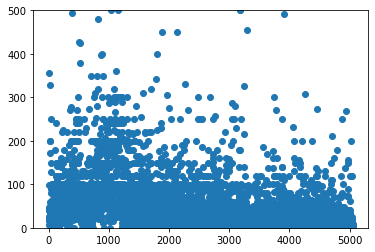

In [52]:
x_values = pd.Series(range(0,len(df_good)))
plt.scatter(x_values, df_good['number'])
plt.ylim(0, 500)
plt.show()

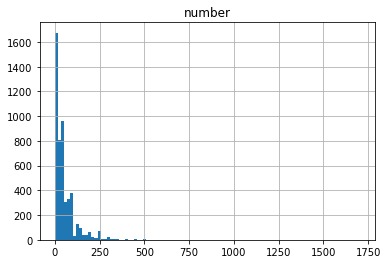

In [53]:
df_good.hist('number', bins=100)
plt.show()

Как видим из графиков, на плотно заставленных заведениями улицах очень много точек с малым количеством мест: скорее всего, тут преобладают ПБО, где еда готовится на вынос.

## Вывод
<a id='output'></a>

К сожалению, у нас нет информации по двум направлениям - денежному (предполагаемый средний чек, рентабельность предприятия и тд) и населению (их преимущественному проживанию в определенной локации, доходу и тд). Поэтому можем основывать свои рекомендации на анализе имеющихся данных. А рекомендации следующие.
- вид объекта - кафе, ресторан, ПБО или столовая
- сеть / не сеть - зависит от амбиций, имеющегося бюджета, запуска пилотной точки
- если примем решение развиваться по сетевой модели и роботы будут +- простыми - наиболее популярно ПБО
- нет разницы, строить ли много точек с малым количеством мест или наоборот. Поэтому с точки зрения окупаемости каждого робота предпочтителен второй вариант 
- для того, чтобы дать рекомендации по расположению точки - у нас нет уже упомянутой выше информации


Презентация: https://drive.google.com/file/d/1XMaRFtxHUnDIen8p-b-keajObJJ0xFiT/view?usp=sharing